Circuito del oráculo para el caso 3:


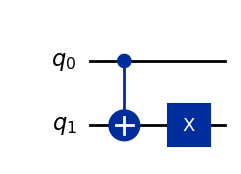

Circuito completo del algoritmo:


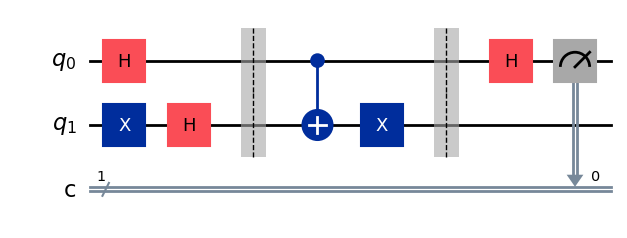

La función del caso 3 es: Balanceada


In [1]:
# %% [markdown]
# # Algoritmo de Deutsch
# Este notebook implementa el algoritmo de Deutsch utilizando Qiskit.
# El objetivo es determinar si una función de 1 bit es constante o balanceada.
# Referencia: Diapositivas 10-16 del archivo "05-Quantum-query-algorithms-slides.pdf".

# %%
# 1. Importaciones necesarias
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# %%
# 2. Definición del Oráculo (La función 'f')
# Existen 4 funciones posibles de 1 bit a 1 bit:
# f1 (constante 0), f2 (balanceada identidad), f3 (balanceada negación), f4 (constante 1).

def deutsch_function(case: int):
    """
    Genera un circuito cuántico para una de las 4 funciones posibles de 1 bit.
    
    Args:
        case (int): 1, 2, 3 o 4.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")
    
    f = QuantumCircuit(2)
    
    # Caso 1: Constante 0 (No hace nada)
    
    # Caso 2: Balanceada (Identidad) -> CNOT
    if case in [2, 3]:
        f.cx(0, 1)
        
    # Caso 3: Balanceada (Negación) -> CNOT + X
    # Caso 4: Constante 1 -> X
    if case in [3, 4]:
        f.x(1)
        
    return f

# Visualizamos la función f3 como ejemplo
print("Circuito del oráculo para el caso 3:")
display(deutsch_function(3).draw(output="mpl"))

# %%
# 3. Compilación del Circuito Completo
# Prepara el estado |-> en el qubit objetivo y aplica Hadamard a ambos registros.

def compile_circuit(function: QuantumCircuit):
    """
    Compila el circuito para el algoritmo de Deutsch.
    
    Args:
        function (QuantumCircuit): El circuito del oráculo.
    """
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    
    # Preparar el qubit ancilla en estado |1> y luego aplicar H -> |->
    qc.x(n)
    qc.h(range(n + 1))
    
    qc.barrier()
    # Aplicar el oráculo (U_f)
    qc.compose(function, inplace=True)
    qc.barrier()
    
    # Interferencia final (Hadamard en la entrada)
    qc.h(range(n))
    
    # Medición
    qc.measure(range(n), range(n))
    
    return qc

# Visualizamos el circuito completo con el oráculo f3
print("Circuito completo del algoritmo:")
display(compile_circuit(deutsch_function(3)).draw(output="mpl"))

# %%
# 4. Ejecución del Algoritmo
# Ejecuta el circuito en un simulador y determina el tipo de función.

def deutsch_algorithm(function: QuantumCircuit):
    """
    Determina si la función es constante o balanceada.
    """
    qc = compile_circuit(function)
    
    # Ejecución en simulador local
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    
    # Si medimos 0, es constante. Si medimos 1, es balanceada.
    if measurements[0] == "0":
        return "Constante"
    return "Balanceada"

# %%
# 5. Prueba
caso_prueba = 3
f = deutsch_function(caso_prueba)
resultado = deutsch_algorithm(f)
print(f"La función del caso {caso_prueba} es: {resultado}")

Ejemplo de oráculo generado:


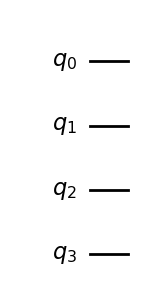

Analizando oráculo...
El algoritmo determinó que la función es: Balanceada


In [2]:
# %% [markdown]
# # Algoritmo de Deutsch-Jozsa
# Generalización del algoritmo de Deutsch para funciones de n bits.
# Determina si una función es constante o balanceada con una sola consulta cuántica.
# Referencia: Diapositivas 17-27 del archivo "05-Quantum-query-algorithms-slides.pdf".

# %%
# 1. Importaciones
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# %%
# 2. Generador de Oráculos Aleatorios (Deutsch-Jozsa)
# Crea una función aleatoria que cumple la promesa (o constante o balanceada).

def dj_query(num_qubits):
    """
    Crea un circuito oráculo para una función aleatoria (constante o balanceada).
    """
    qc = QuantumCircuit(num_qubits + 1)
    
    # 50% probabilidad de ser constante, 50% de ser balanceada
    if np.random.randint(0, 2):
        # Si es constante, decidimos al azar si devuelve 0 o 1
        # Voltear el qubit de salida con 50% de probabilidad hace que sea constante 1
        if np.random.randint(0, 2):
            qc.x(num_qubits)
        return qc # Retorna función constante
    
    # Si llegamos aquí, la función será balanceada.
    # Elegimos la mitad de las entradas posibles para que den salida 1.
    on_states = np.random.choice(
        range(2**num_qubits), 
        2**num_qubits // 2, 
        replace=False
    )
    
    # Función auxiliar para aplicar X gates según la cadena binaria
    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc
    
    for state in on_states:
        qc.barrier() 
        # Convertimos el estado entero a binario
        state_bin = f"{state:0{num_qubits}b}"
        # Aplicamos X para activar el control
        qc = add_cx(qc, state_bin)
        # Multi-controlled X (Toffoli generalizado)
        qc.mcx(list(range(num_qubits)), num_qubits)
        # Revertimos las X
        qc = add_cx(qc, state_bin)
        
    qc.barrier()
    return qc

# Visualización de un oráculo aleatorio de 3 qubits
print("Ejemplo de oráculo generado:")
display(dj_query(3).draw(output="mpl"))

# %%
# 3. Compilación del Circuito DJ
# Estructura idéntica al algoritmo de Deutsch pero para n qubits.

def compile_circuit_dj(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    
    # Preparar estado |-> en el último qubit
    qc.x(n)
    qc.h(range(n + 1))
    
    # Aplicar oráculo
    qc.compose(function, inplace=True)
    
    # Interferencia final en el registro de entrada
    qc.h(range(n))
    
    # Medir registro de entrada
    qc.measure(range(n), range(n))
    return qc

# %%
# 4. Ejecución del Algoritmo

def dj_algorithm(function: QuantumCircuit):
    qc = compile_circuit_dj(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    
    # Si la cadena medida contiene algún '1', es balanceada.
    # Si es todo '0', es constante.
    if "1" in measurements[0]:
        return "Balanceada"
    return "Constante"

# %%
# 5. Prueba
n_bits = 3
oraculo = dj_query(n_bits)
print("Analizando oráculo...")
resultado = dj_algorithm(oraculo)
print(f"El algoritmo determinó que la función es: {resultado}")

Oráculo para la cadena secreta 1011:


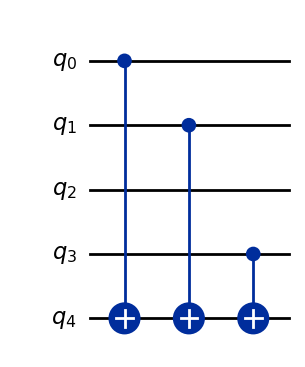

Buscando la cadena oculta...
Cadena original: 1011
Cadena encontrada: 1011
¡Éxito! El algoritmo encontró la cadena oculta en una sola consulta.


In [3]:
# %% [markdown]
# # Algoritmo de Bernstein-Vazirani
# Utiliza la misma estructura de circuito que Deutsch-Jozsa para encontrar una cadena oculta 's'.
# Referencia: Diapositivas 28-29 del archivo "05-Quantum-query-algorithms-slides.pdf".

# %%
# 1. Importaciones
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# %%
# 2. Definición del Oráculo BV
# Construye un oráculo basado en una cadena secreta 's'.
# Si el bit i-ésimo de 's' es 1, aplicamos una CNOT entre la entrada i y el objetivo.

def bv_query(s):
    """
    Crea un oráculo para el problema Bernstein-Vazirani dada la cadena s.
    
    Args:
        s (str): Cadena binaria oculta (ej. "1011")
    """
    n = len(s)
    qc = QuantumCircuit(n + 1)
    
    # La cadena se lee en orden inverso en Qiskit (little-endian) usualmente,
    # pero aquí iteramos sobre la cadena invertida para mapear indices visualmente.
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, n)
            
    return qc

cadena_secreta = "1011"
print(f"Oráculo para la cadena secreta {cadena_secreta}:")
display(bv_query(cadena_secreta).draw(output="mpl"))

# %%
# 3. Compilación del Circuito
# Reutilizamos la lógica de compilación de Deutsch-Jozsa ya que el circuito es estructuralmente idéntico.

def compile_circuit_bv(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    
    qc.x(n)
    qc.h(range(n + 1))
    
    qc.compose(function, inplace=True)
    
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

# %%
# 4. Ejecución del Algoritmo
# La medición final nos dará exactamente la cadena oculta 's'.

def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit_bv(function)
    
    # Ejecutamos 1 solo shot, ya que es determinista
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    
    # Recuperamos la memoria (la cadena medida)
    return result.get_memory()[0]

# %%
# 5. Prueba
s_oculta = "1011"
oraculo_bv = bv_query(s_oculta)

print(f"Buscando la cadena oculta...")
resultado = bv_algorithm(oraculo_bv)

print(f"Cadena original: {s_oculta}")
print(f"Cadena encontrada: {resultado}")

if s_oculta == resultado:
    print("¡Éxito! El algoritmo encontró la cadena oculta en una sola consulta.")
else:
    print("Fallo en la detección.")